In [1]:
%load_ext autoreload
import ddls

Initialise what type(s) of nodes (servers) you want in your cluster and what type(s) of worker(s) you want to populate them with.

In [2]:
%autoreload
from ddls.devices.processors.gpus.A100 import A100

import json


node_config = {'type_1':
                  {
                      'num_nodes': 16,
                      'workers_config': 
                          [
                              {
                               'num_workers': 4,
                               'worker': A100
                              }
                          ]
                  }
              }

print(node_config)

{'type_1': {'num_nodes': 16, 'workers_config': [{'num_workers': 4, 'worker': <class 'ddls.devices.processors.gpus.A100.A100'>}]}}


Initialise the topology to be populated by your nodes.

In [3]:
topology_config = {'type':
                      'torus',
                   'kwargs':
                      {
                          'x_dims': 4,
                          'y_dims': 4
                      }
                  }

Initialise the cluster environment using your node and topology configuration.

Cluster <class 'ddls.clusters.cluster.Cluster'> | Topology: <class 'ddls.topologies.torus.Torus'> with 16 nodes and 32 | Topology config: {'type': 'torus', 'kwargs': {'x_dims': 4, 'y_dims': 4}} | Node config: {'type_1': {'num_nodes': 16, 'workers_config': [{'num_workers': 4, 'worker': <class 'ddls.devices.processors.gpus.A100.A100'>}]}}


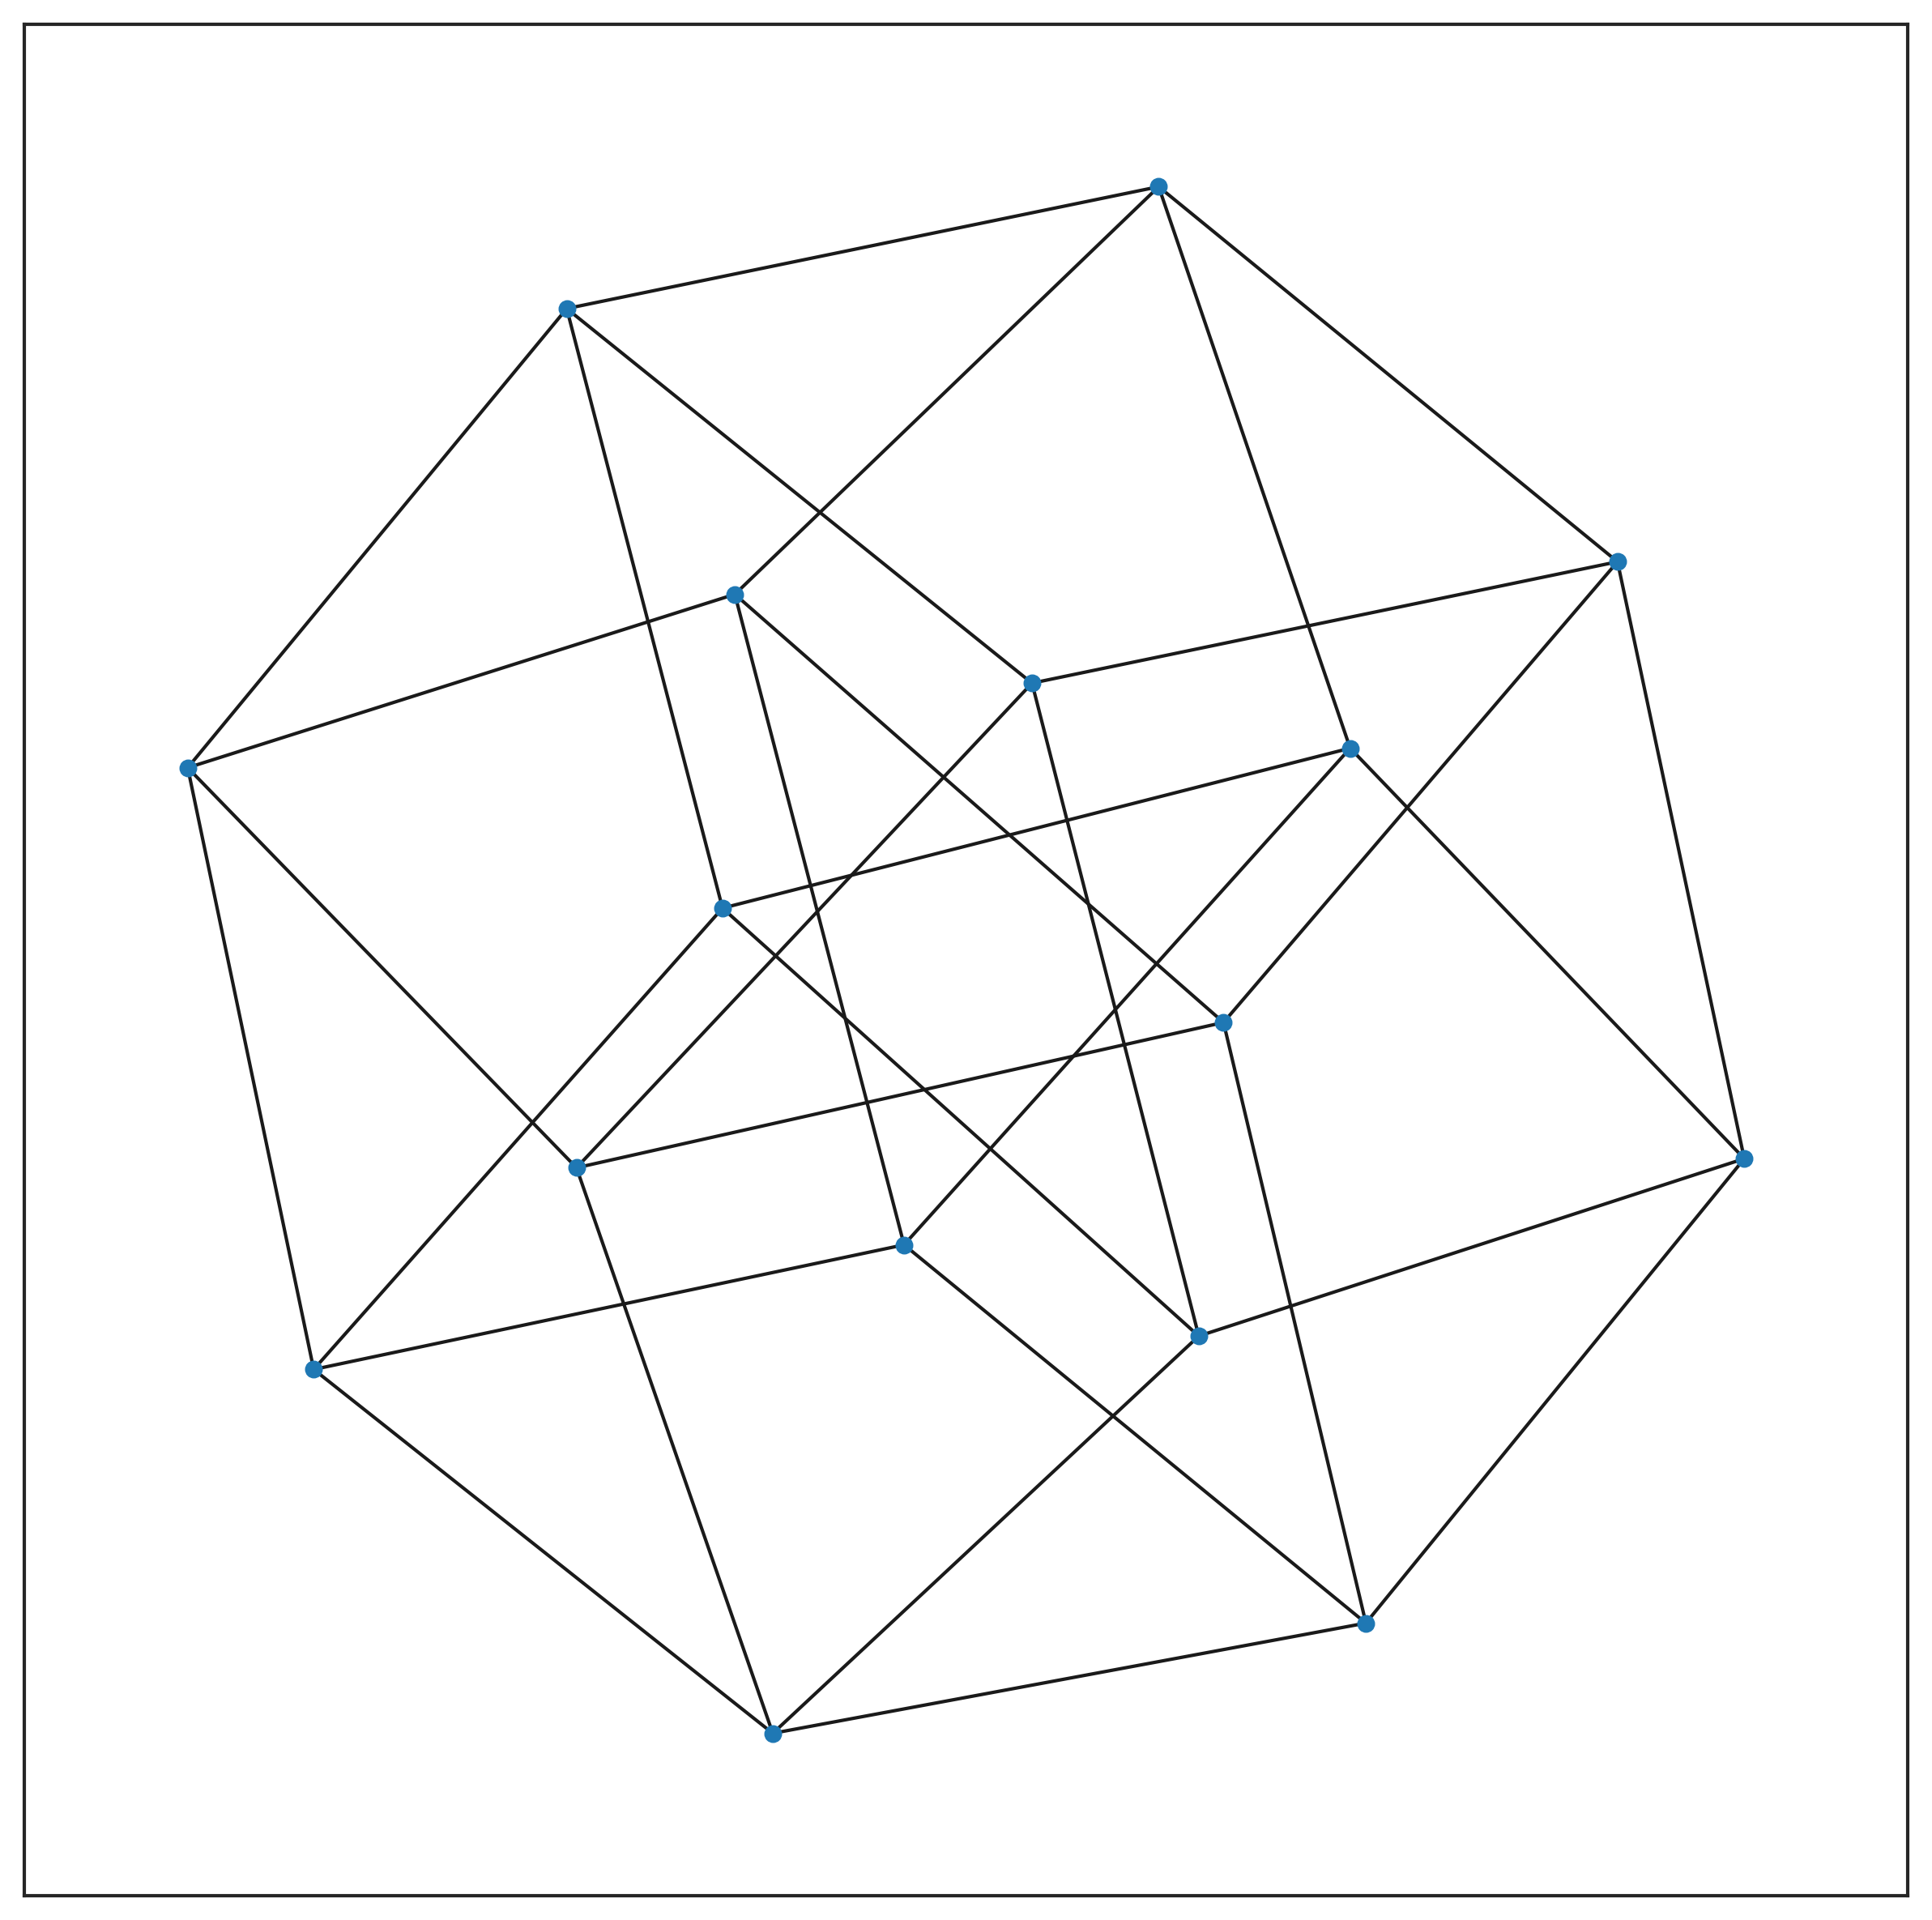

Node 1-1-1: {'workers': {139869550186848: <ddls.devices.processors.gpus.A100.A100 object at 0x7f35eada9160>, 139869550188240: <ddls.devices.processors.gpus.A100.A100 object at 0x7f35eada96d0>, 139869550188528: <ddls.devices.processors.gpus.A100.A100 object at 0x7f35eada97f0>, 139869550189632: <ddls.devices.processors.gpus.A100.A100 object at 0x7f35eada9c40>}}
Node 2-1-1: {'workers': {139869550189488: <ddls.devices.processors.gpus.A100.A100 object at 0x7f35eada9bb0>, 139869550187136: <ddls.devices.processors.gpus.A100.A100 object at 0x7f35eada9280>, 139869550187712: <ddls.devices.processors.gpus.A100.A100 object at 0x7f35eada94c0>, 139869550189680: <ddls.devices.processors.gpus.A100.A100 object at 0x7f35eada9c70>}}
Node 3-1-1: {'workers': {139869550189008: <ddls.devices.processors.gpus.A100.A100 object at 0x7f35eada99d0>, 139869550188336: <ddls.devices.processors.gpus.A100.A100 object at 0x7f35eada9730>, 139869550189872: <ddls.devices.processors.gpus.A100.A100 object at 0x7f35eada9d30>,

In [57]:
%autoreload
from ddls.clusters.cluster import Cluster

env = Cluster(topology_config=topology_config,
              node_config=node_config,
              path_to_save='/scratch/datasets/ddls/sims',
              save_freq=100,
              use_sqlite_database=True)
print(env)
env.topology.render()

for node in env.topology.graph:
    print(f'Node {node}: {env.topology.graph.nodes[node]}')

Load the `ddls` computation graph(s) you want to run on the cluster.

In [58]:
%autoreload
from ddls.utils import ddls_graph_from_pbtxt_file
from ddls.plotting.plotting import plot_computation_graph

import glob


# get file paths
path_to_files = '/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid'
file_paths = glob.glob(path_to_files + '/*')
    
# create ddls graph
num_graphs = 100
ddls_computation_graphs = [ddls_graph_from_pbtxt_file(file_path, processor_type_profiled='A100', verbose=False) for file_path in file_paths[:num_graphs]]

# visualise
visualise = False
if visualise:
    for graph in ddls_computation_graphs:
        fig = plot_computation_graph(graph, scaling_factor=3, title='ddls_graph', show_fig=True, verbose=True)

Initialise `ddls` job(s) from the computation graph(s)

In [59]:
%autoreload
from ddls.demands.jobs.job import Job

jobs = [Job(computation_graph=graph, num_training_steps=2) for graph in ddls_computation_graphs]

for job in jobs:
    print(job)

Job ID: 139869443078944 | # nodes: 96 | # edges: 410 | # training steps: 2 | Total op mem cost: 0 | Total dep size: 13936
Job ID: 139869550190400 | # nodes: 68 | # edges: 128 | # training steps: 2 | Total op mem cost: 0 | Total dep size: 4037
Job ID: 139869550186992 | # nodes: 85 | # edges: 302 | # training steps: 2 | Total op mem cost: 0 | Total dep size: 11394
Job ID: 139869550188192 | # nodes: 156 | # edges: 672 | # training steps: 2 | Total op mem cost: 0 | Total dep size: 22585
Job ID: 139869550188288 | # nodes: 115 | # edges: 328 | # training steps: 2 | Total op mem cost: 0 | Total dep size: 11163
Job ID: 139869525905952 | # nodes: 63 | # edges: 164 | # training steps: 2 | Total op mem cost: 0 | Total dep size: 6252
Job ID: 139869484094368 | # nodes: 149 | # edges: 600 | # training steps: 2 | Total op mem cost: 0 | Total dep size: 20901
Job ID: 139869484097200 | # nodes: 54 | # edges: 124 | # training steps: 2 | Total op mem cost: 0 | Total dep size: 3812
Job ID: 139869484094032 

Initialise an operation placement agent.

In [60]:
%autoreload
from ddls.managers.placers.random_job_placer import RandomJobPlacer
from ddls.managers.schedulers.srpt_job_scheduler import SRPTJobScheduler

control_plane = {
    'job_placer': RandomJobPlacer(),
    'job_scheduler': SRPTJobScheduler()
}

Reset cluster environment and run `Cluster`

In [61]:
%autoreload
from ddls.distributions.uniform import Uniform
from ddls.utils import seed_stochastic_modules_globally

import time
import pprint


seeds = [0, 1, 2]
for seed in seeds:
    print(f'\n\n\n~~~~~~~~~~~~~~~~~~~~~~~ Seed {seed} ~~~~~~~~~~~~~~~~~~~~~~~')
    seed_stochastic_modules_globally(seed)
    obs, action_set, reward, done, info = env.reset(jobs=jobs,
                                                    job_sampling_mode='remove',
                                                    job_interarrival_time_dist=Uniform(min_val=1, max_val=1000),
                                                    max_simulation_run_time=float('inf'),
                                                    job_queue_capacity=10,
                                                    seed=seed,
                                                    verbose=True)
    
    start_time = time.time()
    while not done:
        # make decisions
        actions = {}
        actions['job_placement'] = control_plane['job_placer'].get_placement(cluster=env)
        actions['job_schedule'] = control_plane['job_scheduler'].get_schedule(new_placements=actions['job_placement'], cluster=env)

    #     print('')
    #     print('-'*80)
    #     pprint.pprint(actions)
    #     print('-'*80)
    #     print('')

        # pass actions to cluster environment and move to next step
        obs, action_set, reward, done, info = env.step(actions, verbose=False)

        print(f'Step {env.step_counter} | Jobs arrived: {env.num_jobs_arrived} | completed: {len(env.jobs_completed)} | blocked: {len(env.jobs_blocked)} | running: {len(env.jobs_running)} | queued: {len(env.job_queue)}')

    print(f'\nCompleted simulation in {time.time() - start_time:.3f} s')




~~~~~~~~~~~~~~~~~~~~~~~ Seed 0 ~~~~~~~~~~~~~~~~~~~~~~~
Initialised folder /scratch/datasets/ddls/sims/cluster/cluster_20/reset_1
Reset cluster environment.
Job interarrival time dist: Distribution type: <class 'ddls.distributions.uniform.Uniform'> | min_val: 1 | max_val: 1000 | interval: 1 | decimals: 10
Job sampler: Original pool: [<ddls.demands.jobs.job.Job object at 0x7f35e4783b20>, <ddls.demands.jobs.job.Job object at 0x7f35eada9f40>, <ddls.demands.jobs.job.Job object at 0x7f35eada91f0>, <ddls.demands.jobs.job.Job object at 0x7f35eada96a0>, <ddls.demands.jobs.job.Job object at 0x7f35eada9700>, <ddls.demands.jobs.job.Job object at 0x7f35e9681220>, <ddls.demands.jobs.job.Job object at 0x7f35e6ea13a0>, <ddls.demands.jobs.job.Job object at 0x7f35e6ea1eb0>, <ddls.demands.jobs.job.Job object at 0x7f35e6ea1250>, <ddls.demands.jobs.job.Job object at 0x7f35e6ea12e0>, <ddls.demands.jobs.job.Job object at 0x7f35e6ea1280>, <ddls.demands.jobs.job.Job object at 0x7f35e6ea1100>, <ddls.demands.

Step 6 | Jobs arrived: 7 | completed: 0 | blocked: 0 | running: 6 | queued: 1
Step 7 | Jobs arrived: 8 | completed: 0 | blocked: 0 | running: 7 | queued: 1
Step 8 | Jobs arrived: 9 | completed: 0 | blocked: 0 | running: 8 | queued: 1
Step 9 | Jobs arrived: 10 | completed: 0 | blocked: 0 | running: 9 | queued: 1
Step 10 | Jobs arrived: 11 | completed: 0 | blocked: 0 | running: 10 | queued: 1
Step 11 | Jobs arrived: 12 | completed: 0 | blocked: 0 | running: 11 | queued: 1
Step 12 | Jobs arrived: 13 | completed: 0 | blocked: 0 | running: 12 | queued: 1
Step 13 | Jobs arrived: 14 | completed: 0 | blocked: 0 | running: 13 | queued: 1
Step 14 | Jobs arrived: 15 | completed: 0 | blocked: 0 | running: 14 | queued: 1
Step 15 | Jobs arrived: 16 | completed: 0 | blocked: 0 | running: 15 | queued: 1
Step 16 | Jobs arrived: 17 | completed: 0 | blocked: 0 | running: 16 | queued: 1
Step 17 | Jobs arrived: 18 | completed: 0 | blocked: 0 | running: 17 | queued: 1
Step 18 | Jobs arrived: 19 | completed:

Saved logs to /scratch/datasets/ddls/sims/cluster/cluster_20/reset_1/ in 1.2815 s.
Step 106 | Jobs arrived: 86 | completed: 21 | blocked: 0 | running: 64 | queued: 1
Step 107 | Jobs arrived: 87 | completed: 21 | blocked: 0 | running: 65 | queued: 1
Step 108 | Jobs arrived: 88 | completed: 21 | blocked: 0 | running: 66 | queued: 1
Step 109 | Jobs arrived: 89 | completed: 21 | blocked: 0 | running: 67 | queued: 1
Step 110 | Jobs arrived: 90 | completed: 21 | blocked: 0 | running: 68 | queued: 1
Step 111 | Jobs arrived: 91 | completed: 21 | blocked: 0 | running: 69 | queued: 1
Step 112 | Jobs arrived: 92 | completed: 21 | blocked: 0 | running: 70 | queued: 1
Step 113 | Jobs arrived: 93 | completed: 21 | blocked: 0 | running: 71 | queued: 1
Step 114 | Jobs arrived: 94 | completed: 21 | blocked: 0 | running: 72 | queued: 1
Step 115 | Jobs arrived: 94 | completed: 22 | blocked: 0 | running: 72 | queued: 0
Step 116 | Jobs arrived: 95 | completed: 22 | blocked: 0 | running: 72 | queued: 1
Step

Reset cluster environment.
Job interarrival time dist: Distribution type: <class 'ddls.distributions.uniform.Uniform'> | min_val: 1 | max_val: 1000 | interval: 1 | decimals: 10
Job sampler: Original pool: [<ddls.demands.jobs.job.Job object at 0x7f35e4783b20>, <ddls.demands.jobs.job.Job object at 0x7f35eada9f40>, <ddls.demands.jobs.job.Job object at 0x7f35eada91f0>, <ddls.demands.jobs.job.Job object at 0x7f35eada96a0>, <ddls.demands.jobs.job.Job object at 0x7f35eada9700>, <ddls.demands.jobs.job.Job object at 0x7f35e9681220>, <ddls.demands.jobs.job.Job object at 0x7f35e6ea13a0>, <ddls.demands.jobs.job.Job object at 0x7f35e6ea1eb0>, <ddls.demands.jobs.job.Job object at 0x7f35e6ea1250>, <ddls.demands.jobs.job.Job object at 0x7f35e6ea12e0>, <ddls.demands.jobs.job.Job object at 0x7f35e6ea1280>, <ddls.demands.jobs.job.Job object at 0x7f35e6ea1100>, <ddls.demands.jobs.job.Job object at 0x7f35e96af280>, <ddls.demands.jobs.job.Job object at 0x7f35e96af7f0>, <ddls.demands.jobs.job.Job object at 0

Step 6 | Jobs arrived: 7 | completed: 0 | blocked: 0 | running: 6 | queued: 1
Step 7 | Jobs arrived: 8 | completed: 0 | blocked: 0 | running: 7 | queued: 1
Step 8 | Jobs arrived: 9 | completed: 0 | blocked: 0 | running: 8 | queued: 1
Step 9 | Jobs arrived: 10 | completed: 0 | blocked: 0 | running: 9 | queued: 1
Step 10 | Jobs arrived: 11 | completed: 0 | blocked: 0 | running: 10 | queued: 1
Step 11 | Jobs arrived: 12 | completed: 0 | blocked: 0 | running: 11 | queued: 1
Step 12 | Jobs arrived: 13 | completed: 0 | blocked: 0 | running: 12 | queued: 1
Step 13 | Jobs arrived: 14 | completed: 0 | blocked: 0 | running: 13 | queued: 1
Step 14 | Jobs arrived: 15 | completed: 0 | blocked: 0 | running: 14 | queued: 1
Step 15 | Jobs arrived: 15 | completed: 1 | blocked: 0 | running: 14 | queued: 0
Step 16 | Jobs arrived: 16 | completed: 1 | blocked: 0 | running: 14 | queued: 1
Step 17 | Jobs arrived: 17 | completed: 1 | blocked: 0 | running: 15 | queued: 1
Step 18 | Jobs arrived: 18 | completed:

Step 105 | Jobs arrived: 83 | completed: 23 | blocked: 0 | running: 59 | queued: 1
Step 106 | Jobs arrived: 84 | completed: 23 | blocked: 0 | running: 60 | queued: 1
Step 107 | Jobs arrived: 85 | completed: 23 | blocked: 0 | running: 61 | queued: 1
Step 108 | Jobs arrived: 85 | completed: 24 | blocked: 0 | running: 61 | queued: 0
Step 109 | Jobs arrived: 85 | completed: 25 | blocked: 0 | running: 60 | queued: 0
Step 110 | Jobs arrived: 86 | completed: 25 | blocked: 0 | running: 60 | queued: 1
Step 111 | Jobs arrived: 87 | completed: 25 | blocked: 0 | running: 61 | queued: 1
Step 112 | Jobs arrived: 87 | completed: 26 | blocked: 0 | running: 61 | queued: 0
Step 113 | Jobs arrived: 88 | completed: 26 | blocked: 0 | running: 61 | queued: 1
Step 114 | Jobs arrived: 89 | completed: 26 | blocked: 0 | running: 62 | queued: 1
Step 115 | Jobs arrived: 90 | completed: 26 | blocked: 0 | running: 63 | queued: 1
Step 116 | Jobs arrived: 91 | completed: 26 | blocked: 0 | running: 64 | queued: 1
Step

Reset cluster environment.
Job interarrival time dist: Distribution type: <class 'ddls.distributions.uniform.Uniform'> | min_val: 1 | max_val: 1000 | interval: 1 | decimals: 10
Job sampler: Original pool: [<ddls.demands.jobs.job.Job object at 0x7f35e4783b20>, <ddls.demands.jobs.job.Job object at 0x7f35eada9f40>, <ddls.demands.jobs.job.Job object at 0x7f35eada91f0>, <ddls.demands.jobs.job.Job object at 0x7f35eada96a0>, <ddls.demands.jobs.job.Job object at 0x7f35eada9700>, <ddls.demands.jobs.job.Job object at 0x7f35e9681220>, <ddls.demands.jobs.job.Job object at 0x7f35e6ea13a0>, <ddls.demands.jobs.job.Job object at 0x7f35e6ea1eb0>, <ddls.demands.jobs.job.Job object at 0x7f35e6ea1250>, <ddls.demands.jobs.job.Job object at 0x7f35e6ea12e0>, <ddls.demands.jobs.job.Job object at 0x7f35e6ea1280>, <ddls.demands.jobs.job.Job object at 0x7f35e6ea1100>, <ddls.demands.jobs.job.Job object at 0x7f35e96af280>, <ddls.demands.jobs.job.Job object at 0x7f35e96af7f0>, <ddls.demands.jobs.job.Job object at 0

Step 7 | Jobs arrived: 8 | completed: 0 | blocked: 0 | running: 7 | queued: 1
Step 8 | Jobs arrived: 9 | completed: 0 | blocked: 0 | running: 8 | queued: 1
Step 9 | Jobs arrived: 10 | completed: 0 | blocked: 0 | running: 9 | queued: 1
Step 10 | Jobs arrived: 11 | completed: 0 | blocked: 0 | running: 10 | queued: 1
Step 11 | Jobs arrived: 11 | completed: 1 | blocked: 0 | running: 10 | queued: 0
Step 12 | Jobs arrived: 12 | completed: 1 | blocked: 0 | running: 10 | queued: 1
Step 13 | Jobs arrived: 13 | completed: 1 | blocked: 0 | running: 11 | queued: 1
Step 14 | Jobs arrived: 14 | completed: 1 | blocked: 0 | running: 12 | queued: 1
Step 15 | Jobs arrived: 15 | completed: 1 | blocked: 0 | running: 13 | queued: 1
Step 16 | Jobs arrived: 16 | completed: 1 | blocked: 0 | running: 14 | queued: 1
Step 17 | Jobs arrived: 17 | completed: 1 | blocked: 0 | running: 15 | queued: 1
Step 18 | Jobs arrived: 18 | completed: 1 | blocked: 0 | running: 16 | queued: 1
Step 19 | Jobs arrived: 19 | complet

Saved logs to /scratch/datasets/ddls/sims/cluster/cluster_20/reset_3/ in 1.3299 s.
Step 106 | Jobs arrived: 81 | completed: 26 | blocked: 0 | running: 54 | queued: 1
Step 107 | Jobs arrived: 82 | completed: 26 | blocked: 0 | running: 55 | queued: 1
Step 108 | Jobs arrived: 83 | completed: 26 | blocked: 0 | running: 56 | queued: 1
Step 109 | Jobs arrived: 84 | completed: 26 | blocked: 0 | running: 57 | queued: 1
Step 110 | Jobs arrived: 85 | completed: 26 | blocked: 0 | running: 58 | queued: 1
Step 111 | Jobs arrived: 86 | completed: 26 | blocked: 0 | running: 59 | queued: 1
Step 112 | Jobs arrived: 86 | completed: 27 | blocked: 0 | running: 59 | queued: 0
Step 113 | Jobs arrived: 87 | completed: 27 | blocked: 0 | running: 59 | queued: 1
Step 114 | Jobs arrived: 88 | completed: 27 | blocked: 0 | running: 60 | queued: 1
Step 115 | Jobs arrived: 89 | completed: 27 | blocked: 0 | running: 61 | queued: 1
Step 116 | Jobs arrived: 89 | completed: 28 | blocked: 0 | running: 61 | queued: 0
Step

**TODO**: Implement logic for placing job ops of each job -> step env -> time job completion for 1 training step (can then think about $n$ training steps, network communication overhead, etc.)

- Have mounted job onto devices
- Now need to work out way of tracking ops running on each device efficiently and timing how long they take. Consider having global dict tracking operations which are running to avoid having to keep looping through all ops to check dependencies. Consider also having stopwatch object similar to Noah's where only tick it when have stacked enough sequential operations. N.B. Think should assume that, once ops have been placed on a device, they must be ran sequentially (i.e. cannot run multiple ops on one device at the same time; assume time profile is for e.g. GPU worker running just that one op with <= all its cores)

Lets load our SQLite logs and plot some data.

In [62]:
%autoreload
from collections import defaultdict
from sqlitedict import SqliteDict
import pprint
import glob


# database_path = env.path_to_save + '/database/'
agent = 'rand_placement'

paths = [reset_folder for reset_folder in glob.glob(env.path_to_save + '/*/')]
print(paths)

# steps_logs_dict = defaultdict(dict)
steps_logs_dict = defaultdict(lambda : defaultdict(list))
for path in paths:
    with SqliteDict(path + '/steps_log.sqlite') as log:
        for key, val in log.items():
            steps_logs_dict[agent][key].extend(val)
        log.close()
print(f'steps_logs_dict: {steps_logs_dict}')

# sim_logs_dict = defaultdict(dict)
sim_logs_dict = defaultdict(lambda : defaultdict(list))
for path in paths:
    with SqliteDict(path + '/sim_log.sqlite') as log:
        for key, val in log.items():
            sim_logs_dict[agent][key] = val
        log.close()
print(f'sim_logs_dict: {sim_logs_dict}')

['/scratch/datasets/ddls/sims/cluster/cluster_20/reset_2/', '/scratch/datasets/ddls/sims/cluster/cluster_20/reset_1/', '/scratch/datasets/ddls/sims/cluster/cluster_20/reset_3/']
steps_logs_dict: defaultdict(<function <lambda> at 0x7f35e9f0d5e0>, {'rand_placement': defaultdict(<class 'list'>, {'step_counter': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,

sim_logs_dict: defaultdict(<function <lambda> at 0x7f35e6bd2790>, {'rand_placement': defaultdict(<class 'list'>, {'job_completion_time': [5677, 12561, 13206, 16961, 19232, 20429, 17663, 19108, 26825, 24612, 23216, 24170, 18070, 25720, 11949, 33506, 25715, 23449, 15721, 21068, 32188, 24159, 19660, 33117, 36903, 22851, 27194, 40836, 25817, 20631, 25653, 23252, 47529, 43864, 35081, 40020, 53603, 43568, 39124, 36949, 48286, 25461, 44039, 53553, 38357, 18048, 41694, 39546, 22463, 43164, 19501, 19139, 30449, 42244, 21103, 24276, 21216, 27193, 22674, 44018, 30290, 29281, 25933, 29541, 33302, 35857, 25754, 35557, 38042, 37017, 50545, 30103, 41053, 43254, 36788, 43280, 32818, 38617, 56239, 44387, 37193, 44406, 50956, 44801, 43211, 54173, 36371, 51745, 50732, 51368, 51125, 56621, 61106, 55193, 56480, 82590, 69341, 62733, 85737, 76052], 'jobs_completed_num_nodes': [115, 54, 98, 115, 86, 103, 51, 60, 125, 120, 68, 114, 177, 143, 55, 152, 63, 70, 55, 180, 115, 148, 74, 133, 122, 171, 71, 180, 182, 

## Step-level metrics

E.g. How many jobs, if any, were completed at each step?

In [53]:
import copy

def augment_steps_logs_dict(steps_logs_dict):
    '''Calculates additional metrics for steps logs dict.'''
    _steps_logs_dict = copy.deepcopy(steps_logs_dict)
    for agent in steps_logs_dict.keys():
        _steps_logs_dict[agent]['step_time'] = [steps_logs_dict[agent]['step_end_time'][i] - steps_logs_dict[agent]['step_start_time'][i] for i in range(len(steps_logs_dict[agent]['step_start_time']))]
    return _steps_logs_dict
steps_logs_dict = augment_steps_logs_dict(steps_logs_dict)

Metrics to plot: ['step_start_time', 'mean_num_active_workers', 'num_jobs_completed', 'num_jobs_running', 'num_jobs_arrived', 'num_jobs_blocked', 'step_end_time', 'job_queue_length', 'step_time']
Metrics to skip: {'step_counter'}

Plotting metric step_start_time


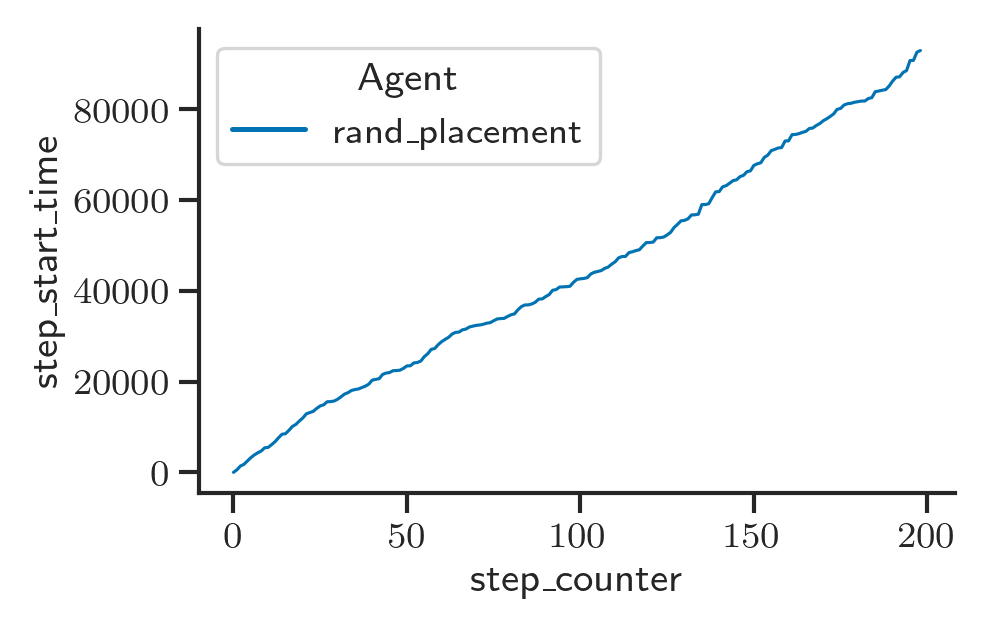

Plotting metric mean_num_active_workers


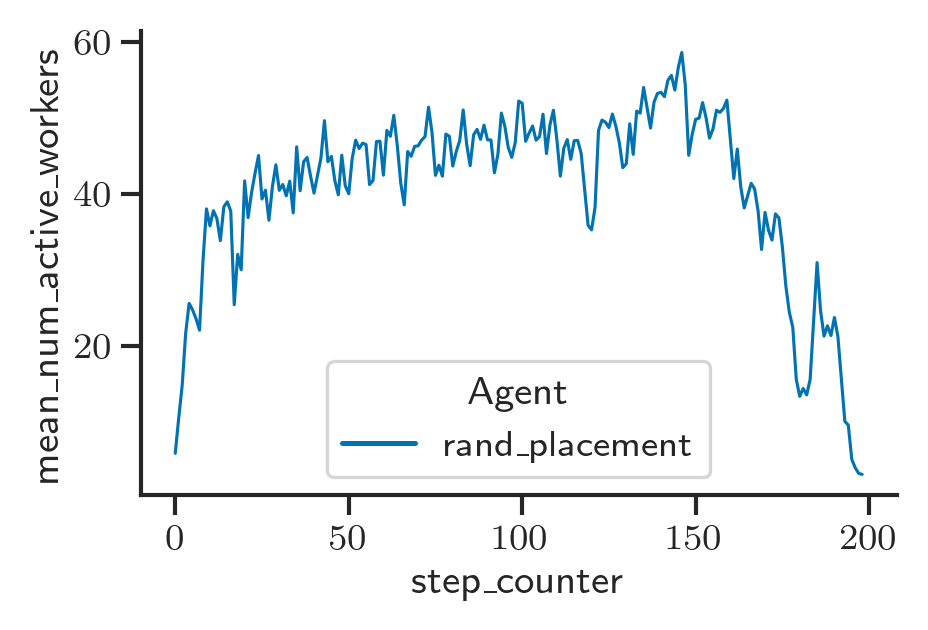

Plotting metric num_jobs_completed


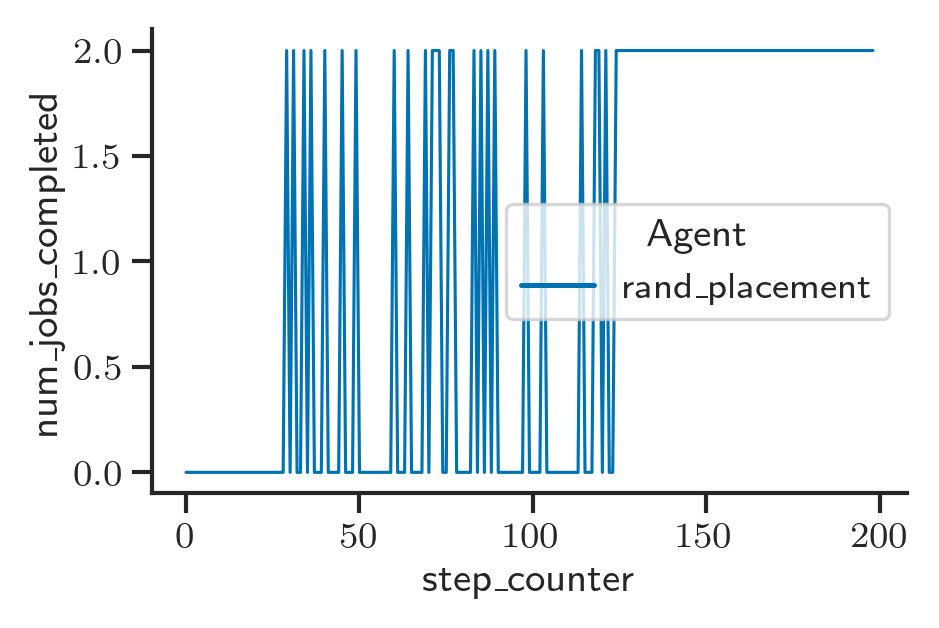

Plotting metric num_jobs_running


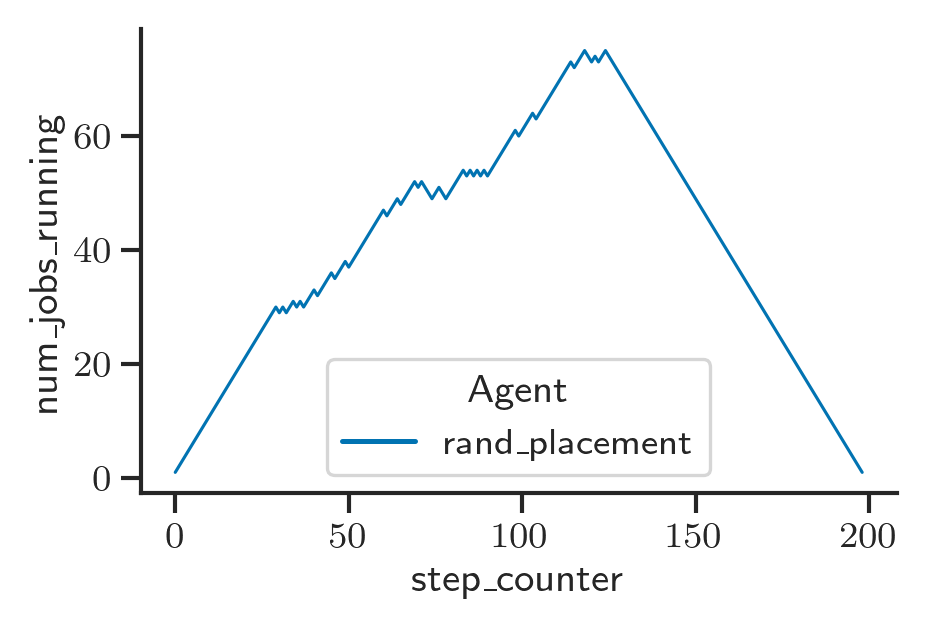

Plotting metric num_jobs_arrived


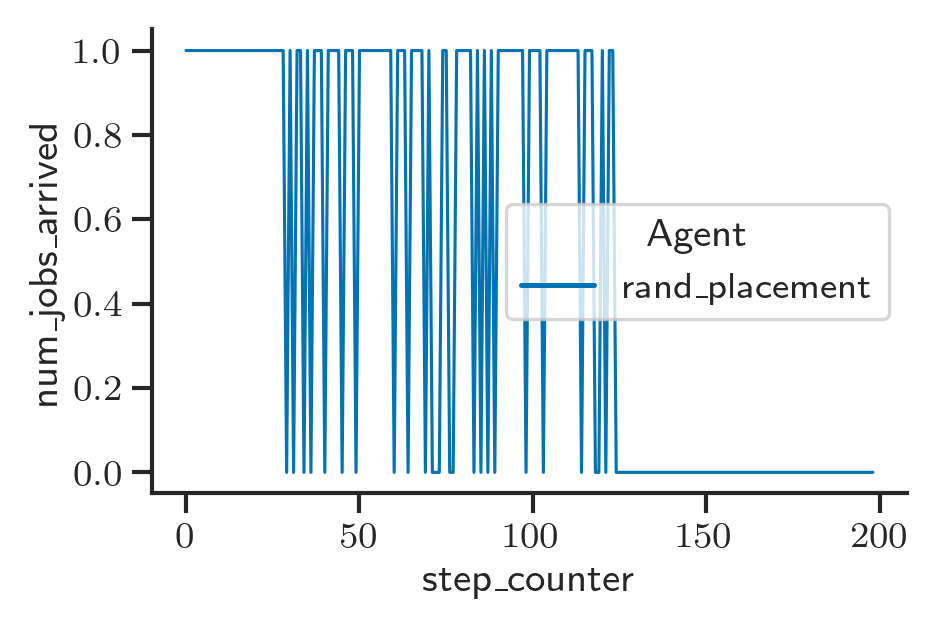

Plotting metric num_jobs_blocked


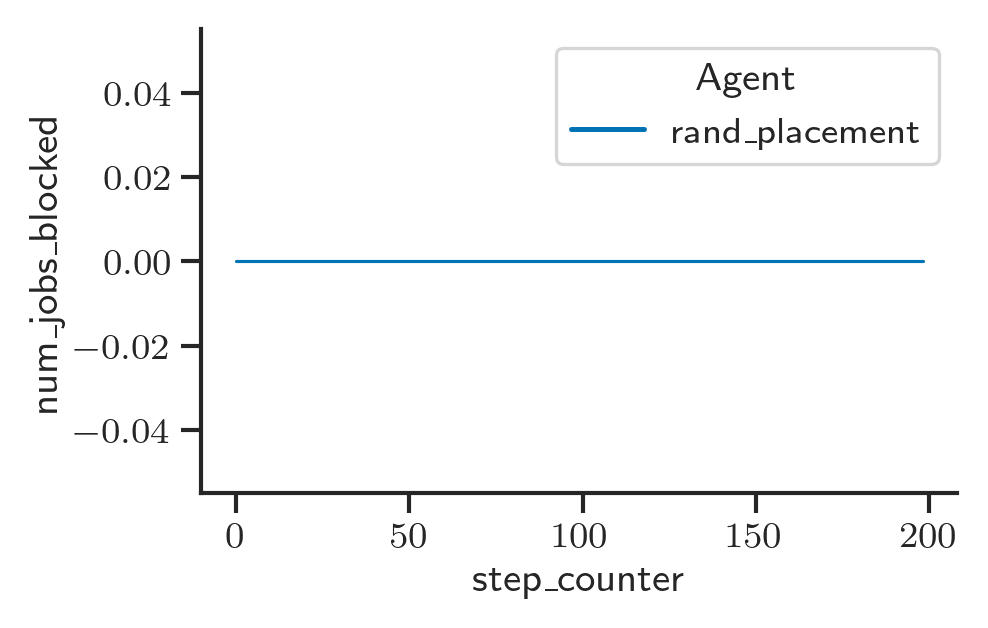

Plotting metric step_end_time


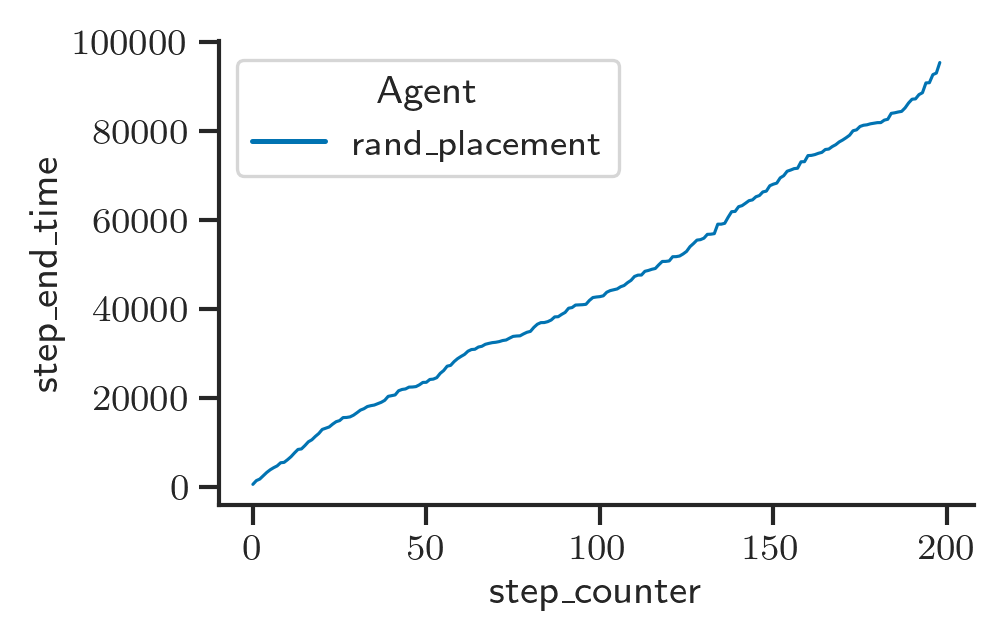

Plotting metric job_queue_length


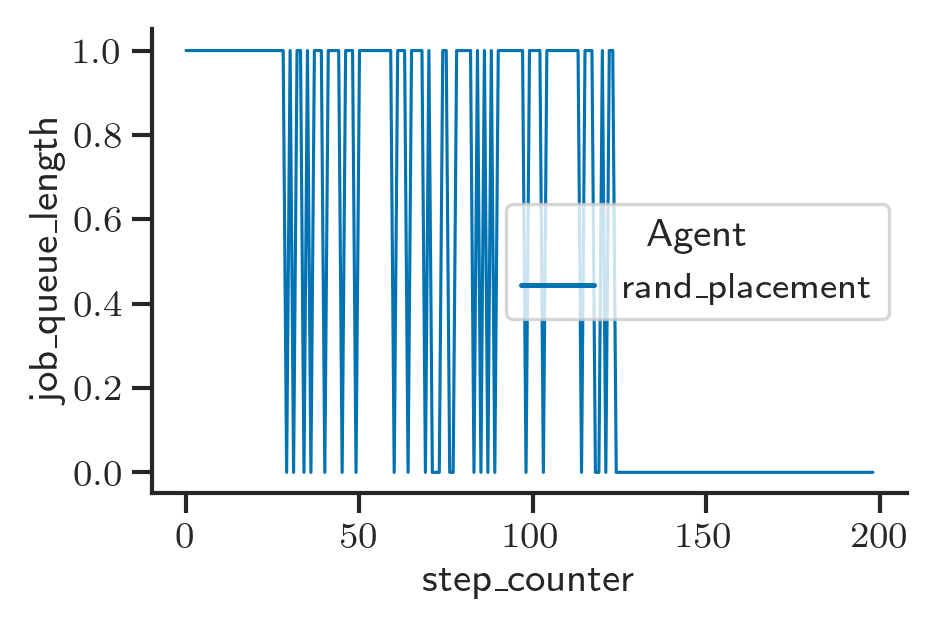

Plotting metric step_time


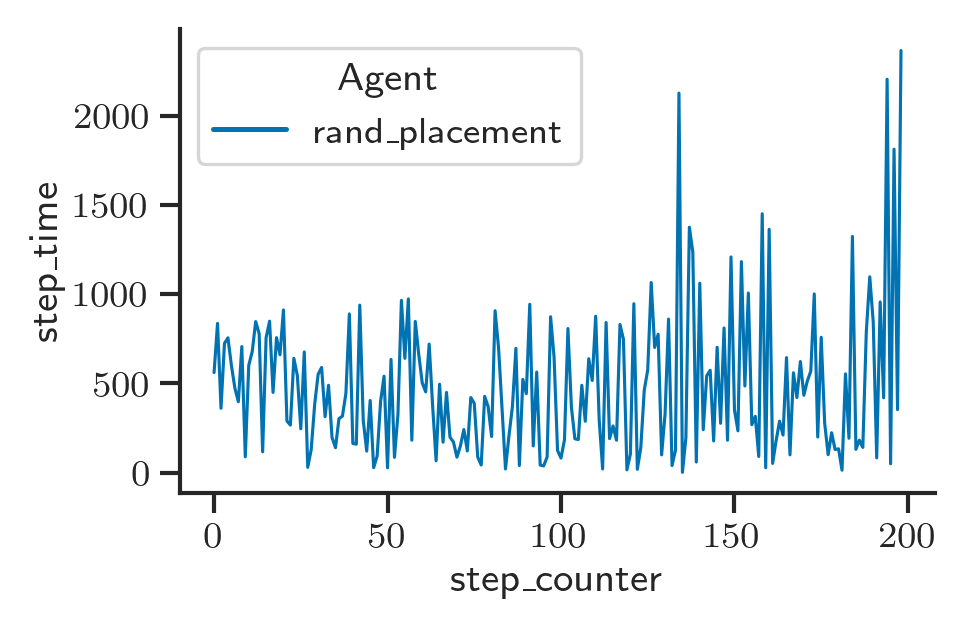

In [54]:
%autoreload
from ddls.plotting.plotting import plot_line

import pandas as pd
from collections import defaultdict


# plot config
x = 'step_counter'
scaling_factor = 1
metrics_to_skip = {'step_counter'}

# make plots
metrics = steps_logs_dict[agent].keys()
metrics_to_plot = [metric for metric in metrics if metric not in metrics_to_skip]
print(f'Metrics to plot: {metrics_to_plot}\nMetrics to skip: {metrics_to_skip}\n')
for metric in metrics_to_plot:
    print(f'Plotting metric {metric}')
    plot_dict = {}
    for _agent in steps_logs_dict.keys():
        plot_dict['Agent'] = [_agent for _ in range(len(steps_logs_dict[_agent][metric]))]
        plot_dict[x] = steps_logs_dict[_agent][x]
        plot_dict[metric] = steps_logs_dict[agent][metric]
    fig = plot_line(pd.DataFrame(plot_dict), 
                    x=x, 
                    y=metric, 
                    hue='Agent', 
                    xlabel=x, 
                    ylabel=metric, 
                    scaling_factor=scaling_factor,
                    show_fig=True)

## Sim-level metrics

E.g. Mean job completion time?

In [ ]:
# import copy
# import numpy as np

# def augment_sim_logs_dict(sim_logs_dict):
#     '''Calculates additional metrics for steps logs dict.'''
#     _sim_logs_dict = copy.deepcopy(sim_logs_dict)
#     for agent in sim_logs_dict.keys():
#         for metric in ['job_completion_time']:
#             _sim_logs_dict[agent][f'mean_{metric}'] = np.mean(sim_logs_dict[agent][metric])
#             _sim_logs_dict[agent][f'p99_{metric}'] = np.percentile(sim_logs_dict[agent][metric], 99)
#             _sim_logs_dict[agent][f'median_{metric}'] = np.median(sim_logs_dict[agent][metric])
#             _sim_logs_dict[agent][f'std_{metric}'] = np.std(sim_logs_dict[agent][metric])
#     return _sim_logs_dict
# sim_logs_dict = augment_sim_logs_dict(sim_logs_dict)

In [ ]:
%autoreload
from ddls.plotting.plotting import plot_bar, plot_hist

import pandas as pd
from collections import defaultdict
import numpy as np
import scipy.stats as st


# plot config
scaling_factor = 1
metrics_to_skip = {}
estimators = {'mean': np.mean,
              'median': np.mean,
              'iqr': st.iqr,
              'gmean': st.gmean}


# make plots
metrics = sim_logs_dict[agent].keys()
metrics_to_plot = [metric for metric in metrics if metric not in metrics_to_skip]
print(f'Metrics to plot: {metrics_to_plot}\nMetrics to skip: {metrics_to_skip}\n')
for metric in metrics_to_plot:
    print(f'Plotting metric {metric}')
    plot_dict = {}
    for _agent in sim_logs_dict.keys():
        plot_dict['Agent'] = [_agent for _ in range(len(sim_logs_dict[_agent][metric]))]
        plot_dict[metric] = sim_logs_dict[agent][metric]
        
    df = pd.DataFrame(plot_dict)
        
    # hist
    fig = plot_hist(df,
                    x=metric,
                    hue='Agent',
                    xlabel=metric,
                    element='bars',
                    fill=True,
                    cumulative=False,
                    stat='count',
                    multiple='layer',
                    scaling_factor=scaling_factor,
                    show_fig=True)
    
    # cdf
    fig = plot_hist(df,
                    x=metric,
                    hue='Agent',
                    xlabel=metric,
                    element='step',
                    fill=False,
                    cumulative=True,
                    stat='density',
                    common_norm=False,
                    scaling_factor=scaling_factor,
                    show_fig=True)
        
    # bar chart
    for estimator_name, estimator in estimators.items():
        fig = plot_bar(df, 
                        x='Agent', 
                        y=metric, 
                        xlabel='Agent', 
                        ylabel=metric, 
                        estimator=estimator,
                        title=estimator_name,
                        scaling_factor=scaling_factor,
                        show_fig=True)